In [ ]:
!git clone https://github.com/marcin119a/lstm-pycbc.git
%cd lstm-pycbc

Cloning into 'lstm-pycbc'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 199 (delta 15), reused 28 (delta 8), pack-reused 163
Receiving objects: 100% (199/199), 10.75 MiB | 33.46 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/content/lstm-pycbc


In [ ]:
%%capture
!pip install -r requirements.txt

In [8]:
!python dump_dataset.py -m1=10 -m2=20 -n=100 -time_steps=300 -quark=True

2020-09-22 10:38:53.224229: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [73]:
import hickle as hkl


array_hkl = hkl.load('/content/lstm-pycbc/D-SET(100,300).hkl')
X_train = array_hkl.get('xtrain')
X_test = array_hkl.get('xtest')
y_train = array_hkl.get('ytrain')
y_test = array_hkl.get('ytest')

In [75]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], 1)

In [89]:
X_train

array([[[ 2.04318472e-05],
        [-2.55932519e-05],
        [ 4.71781949e-05],
        ...,
        [ 7.35518111e-02],
        [ 7.05104281e-02],
        [ 6.71691114e-02]],

       [[ 2.24216231e-05],
        [-4.25443699e-05],
        [ 6.63318913e-05],
        ...,
        [ 6.87661028e-02],
        [ 6.51816295e-02],
        [ 6.13118831e-02]],

       [[-4.06727180e-06],
        [ 3.93711946e-06],
        [-8.22808639e-06],
        ...,
        [ 7.35341581e-02],
        [ 7.05480009e-02],
        [ 6.72677161e-02]],

       ...,

       [[-1.32629359e-05],
        [ 1.21126312e-05],
        [-2.60927832e-05],
        ...,
        [ 6.94900342e-02],
        [ 6.60274331e-02],
        [ 6.22805000e-02]],

       [[-2.45500267e-05],
        [ 2.10332285e-05],
        [-4.68956260e-05],
        ...,
        [ 6.84783167e-02],
        [ 6.49127477e-02],
        [ 6.10659354e-02]],

       [[-5.04310704e-05],
        [ 3.66350074e-05],
        [-9.02161785e-05],
        ...,
        

In [83]:
y_train = y_train.reshape(y_train.shape[0], 1, 1)

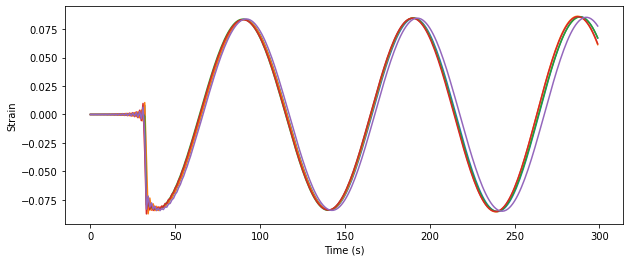

In [76]:
import pylab 
pylab.figure(figsize=(10,4))
for x in range(0,5):
  pylab.plot(X_train[x])
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

In [77]:
from keras.initializers import glorot_normal
from keras.regularizers import l1,l2
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

def create_model(activation='tanh', lr=1e-3, reg=0.0, dropout=0.0):
    """
    Return a neural network model given the hyperparameters.
    """
    n_steps_in, n_steps_out = X_train.shape[1], 1
    n_features = 1

    model = Sequential()
    model.add(LSTM(32,
                   batch_input_shape    = (None, n_steps_in, n_features),
                   activation           = activation,
                   kernel_regularizer   = l2(reg),
                   kernel_initializer   = glorot_normal(),
                   bias_initializer     = 'ones',
                   dropout              = dropout,
                   name                 = 'ONE',
                   return_sequences     = True)
    )
    model.add(LSTM(32, 
                   activation           = activation))
    model.add(Dense(n_steps_out,
                    activation          = activation,
                    kernel_regularizer  = l2(reg),
                    kernel_initializer  = glorot_normal(),
                    name                = 'TWO'))
    model.compile(optimizer='adam', loss='mse')

    return model

In [85]:
model = create_model()

In [86]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np

space = {
    'activation':hp.choice('activation', ('relu', 'tanh')),
    'lr':hp.loguniform('lr', np.log(1e-6), np.log(1e-2)), 
    'reg':hp.uniform('reg', 1e-6, 1e-3)
}

# define loss function
def loss(params):
    
    model = create_model(**params)

    _ = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=1)
    print('Loss: {}'.format(val_loss))
    
    return {'loss':val_loss, 'status':STATUS_OK}

In [87]:
print('Begin tuning')
print('------------')
trials = Trials()
best_params = fmin(loss,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 20,
                   trials = trials)
print('')
print('Best parameters:')
print('----------------')
best_params['activation'] = ['relu', 'tanh'][best_params['activation']]
for k, v in best_params.items():
    print('{} = {}'.format(k, v))

Begin tuning
------------
  0%|          | 0/20 [00:02<?, ?it/s, best loss: ?]


ValueError: ignored

In [68]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.optimizers as optim
from keras.regularizers import l1,l2

def create_model(activation='tanh', lr=1e-3, reg=0.0, dropout=0.0):
  n_steps_in, n_steps_out = X_train.shape[1], 1
  n_features = 1
  model = Sequential()
  model.add(LSTM(200, activation=activation, dropout = dropout, kernel_regularizer = l2(reg), return_sequences=True, batch_input_shape=(None, n_steps_in, n_features)))
  model.add(LSTM(200, activation=activation, dropout = dropout, kernel_regularizer = l2(reg)))
  model.add(Dense(n_steps_out, kernel_regularizer = l2(reg)))
  model.compile(optimizer='adam', loss='mse')
  
  return model